## Adding Noise Tutorial

This tutorial has the objective of guiding through the process of adding noise to ground truth spectra in order to create noisy simulated data which imitates the in vivo data of edited-MRS scans.

The noising process will be divided in 3 different types:
* Random Gaussian Amplitude Noise
* Random Gaussian Frequency Noise
* Random Gaussian Phase Noise

Each step will be presented individually and then together for visualizing the final effect. The same principles for adding noise are used in the provided baseline solution for the challenge.

In [30]:
# Importing base packages
import numpy as np
import matplotlib.pyplot as plt
import math

### Base Data

The base format to which noise will be added is the Free Induction Decay (FID) of both edit-ON and edit-OFF subspectra. These ground-truths are stored as 2 complex arrays (1 for edit-ON and 1 for edit-OFF) per scan in the following format: (# of scans vs # of time points # of subspectra). The array for the time dimension is also provided.

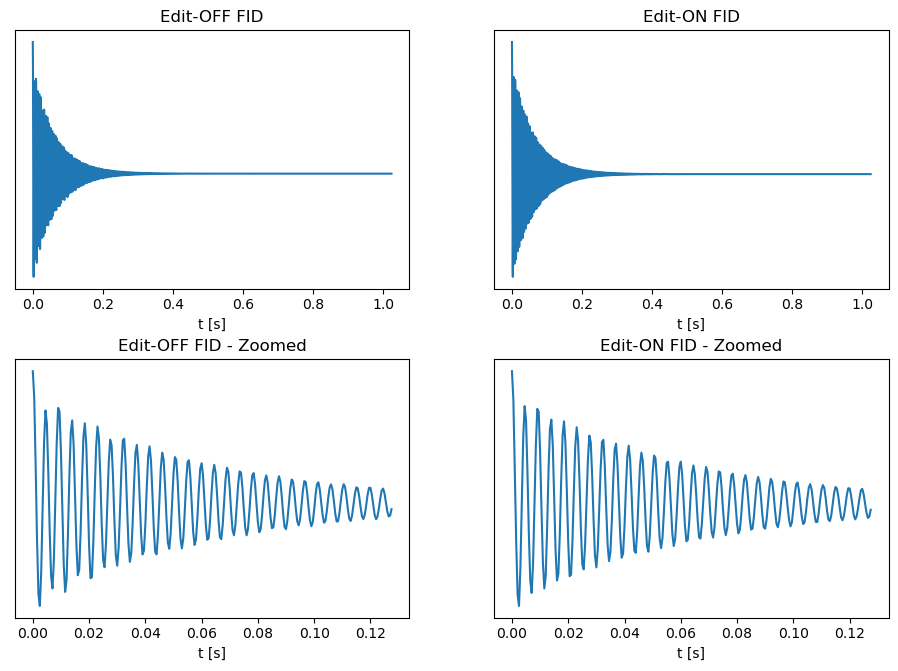

In [10]:
# loading fid from file
fid = np.load("data/ground_truth_fids.npy")
t = np.load("data/t.npy")

fig,ax = plt.subplots(3,2,figsize=(10,7))
fig.tight_layout(pad=3.0)


## Plotting each subspectra fid, whole array and zoomed for better results

ax[0][0].plot(t[0],np.real(fid[0,:,0]))
ax[0][0].set_title("Edit-OFF FID")
ax[0][0].set_xlabel("t [s]")
ax[0][0].set_yticks([])

ax[0][1].plot(t[0],np.real(fid[0,:,1]))
ax[0][1].set_title("Edit-ON FID")
ax[0][1].set_xlabel("t [s]")
ax[0][1].set_yticks([])

ax[1][0].plot(t[0,:256],np.real(fid[0,:256,0]))
ax[1][0].set_title("Edit-OFF FID - Zoomed")
ax[1][0].set_xlabel("t [s]")
ax[1][0].set_yticks([])

ax[1][1].plot(t[0,:256],np.real(fid[0,:256,1]))
ax[1][1].set_title("Edit-ON FID - Zoomed")
ax[1][1].set_xlabel("t [s]")
ax[1][1].set_yticks([])

plt.show()

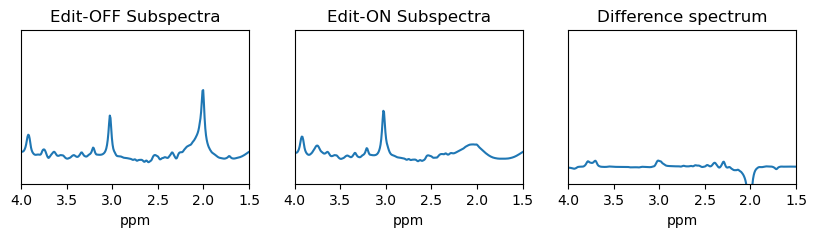

In [16]:
# base data - spectra

# converting fids to spectra and loading ppm
spec = np.fft.fftshift(np.fft.ifft(fid,axis=1),axes=1)
diff_spec = spec[:,:,1]-spec[:,:,0]
ppm = np.load("data/ppm.npy")

# plotting each subspectra and the difference spectrum
fig,ax = plt.subplots(1,3,figsize=(10,2))

ax[0].plot(ppm[0],np.real(spec[0,:,0]))
ax[0].set_title("Edit-OFF Subspectra")

ax[1].plot(ppm[0],np.real(spec[0,:,1]))
ax[1].set_title("Edit-ON Subspectra")

ax[2].plot(ppm[0],np.real(diff_spec[0]))
ax[2].set_title("Difference spectrum")

# improving visualization and focusing on area of interest
for i in range(0,3):
    ax[i].set_xlim(1.5,4)
    ax[i].set_xlabel("ppm")
    ax[i].invert_xaxis()
    ax[i].set_yticks([])
    ax[i].set_ylim(-0.5,4)

plt.show()




### 1. Random Gaussian Amplitude Noise

The random gaussian amplitude noise consists of adding a normally distributed noise to all points of the fid, which will cause noise also in the reconstructed spectra. The mean of this noise will be always zero and the standard deviation can be different by transient and by scan, resulting in higher and lower quality scans and noise. 

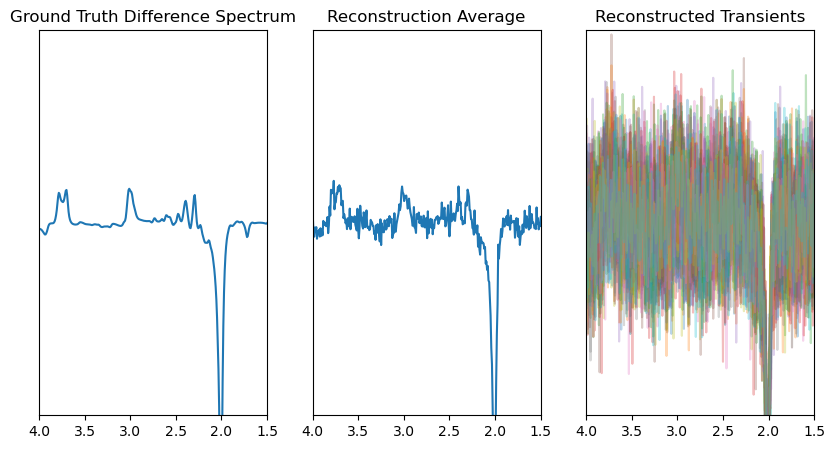

In [29]:
# The first step to add noise will be to copy the fid array and expand its dimensions to create a transient number index
noise_fid = np.expand_dims(fid.copy(),axis=3)

# let's make the fids with 40 transients per subspectra
noise_fid = np.repeat(noise_fid,40,axis=3)

#parameters for creating noise
base_noise = 10

noise = np.random.normal(0,base_noise,size=noise_fid.shape)

noise_fid = noise_fid+noise

#now let's compare the spectra with and without the noise
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[0,:,1,:]-noise_spec[0,:,0,:]

fig,ax = plt.subplots(1,3,figsize = (10,5))

ax[0].plot(ppm[0],np.real(diff_spec[0]))
ax[0].set_title("Ground Truth Difference Spectrum")

ax[1].plot(ppm[0],np.real(noise_diff_spec.mean(axis=1)))
ax[1].set_title("Reconstruction Average")

for i in range(noise_diff_spec.shape[1]):
    ax[2].plot(ppm[0],np.real(noise_diff_spec[:,i]),alpha=0.3)
ax[2].set_title("Reconstructed Transients")

for i in range(3):
    ax[i].set_xlim(1.5,4)
    ax[i].invert_xaxis()
    ax[i].set_ylim(-1,1)
    ax[i].set_yticks([])


plt.show()

### 2. Random Frequency Noise

The random frequency noise consists in shifts to the frequency of the fid, which translate into horizontal translations to the spectra. Those shifts are usually corrected during the phase and frequency correction stage of conventional pipelines and if uncorrected it may lead to subtraction artifacts in the difference spectra due to the misalignment of the subspectra.

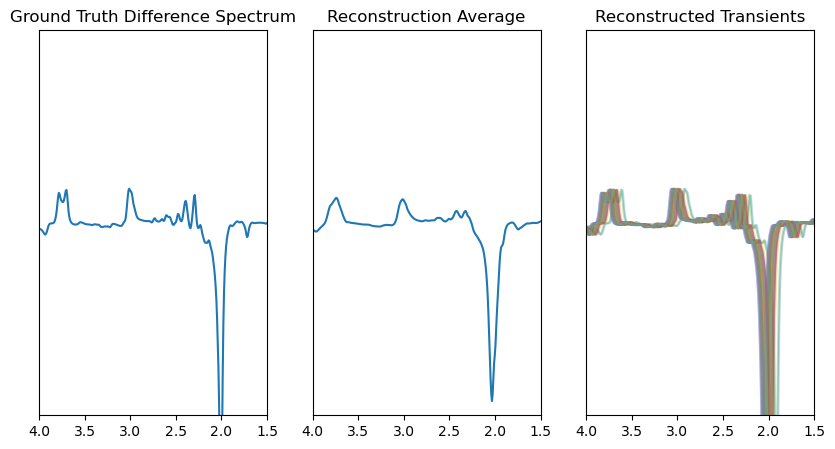

In [31]:
# The first step to add noise will be to copy the fid array and expand its dimensions to create a transient number index
noise_fid = np.expand_dims(fid.copy(),axis=3)

# let's make the fids with 40 transients per subspectra
noise_fid = np.repeat(noise_fid,40,axis=3)

# we are going to use a normal distribution of shifts, centered in 0 and with 20Hz of standard deviation
# differently from the previous noise, there's only one value of shift per transient.

freq_shift_std=20
freq_shifts = np.random.normal(0,freq_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))

# adding noise
noise_fid = noise_fid*np.exp(1j*(freq_shifts*t.reshape(t.shape[0],t.shape[1],1,1)*math.pi/2))

#now let's compare the spectra with and without the noise
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[0,:,1,:]-noise_spec[0,:,0,:]

fig,ax = plt.subplots(1,3,figsize = (10,5))

ax[0].plot(ppm[0],np.real(diff_spec[0]))
ax[0].set_title("Ground Truth Difference Spectrum")

ax[1].plot(ppm[0],np.real(noise_diff_spec.mean(axis=1)))
ax[1].set_title("Reconstruction Average")

for i in range(noise_diff_spec.shape[1]):
    ax[2].plot(ppm[0],np.real(noise_diff_spec[:,i]),alpha=0.3)
ax[2].set_title("Reconstructed Transients")

for i in range(3):
    ax[i].set_xlim(1.5,4)
    ax[i].invert_xaxis()
    ax[i].set_ylim(-1,1)
    ax[i].set_yticks([])


plt.show()

### 3. Random Phase Noise

The random frequency noise consists in phase shifts for the fids, in which a rotation across the complex plane is applied to the whole signal. These shifts are also corrected during frequency and phase correction and can lead to subtraction artifacts. Again, a single phase shift value is applied per transient.

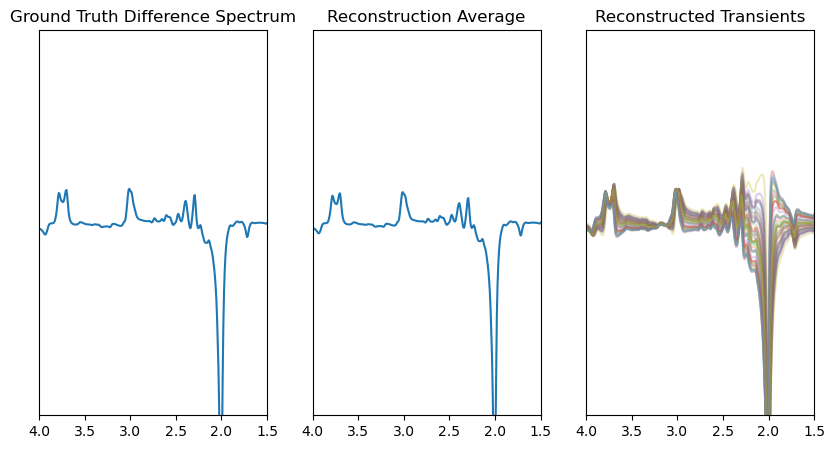

In [32]:
# The first step to add noise will be to copy the fid array and expand its dimensions to create a transient number index
noise_fid = np.expand_dims(fid.copy(),axis=3)

# let's make the fids with 40 transients per subspectra
noise_fid = np.repeat(noise_fid,40,axis=3)

# we are going to use a normal distribution of phase shifts, centered in 0 and with 30 Degrees of standard deviation

phase_shift_std=30
phase_shifts = np.random.normal(0,phase_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))

# adding noise
noise_fid = noise_fid*np.exp(1j*(phase_shifts*np.ones((t.shape[0],t.shape[1],1,1))*math.pi/180))

#now let's compare the spectra with and without the noise
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[0,:,1,:]-noise_spec[0,:,0,:]

fig,ax = plt.subplots(1,3,figsize = (10,5))

ax[0].plot(ppm[0],np.real(diff_spec[0]))
ax[0].set_title("Ground Truth Difference Spectrum")

ax[1].plot(ppm[0],np.real(noise_diff_spec.mean(axis=1)))
ax[1].set_title("Reconstruction Average")

for i in range(noise_diff_spec.shape[1]):
    ax[2].plot(ppm[0],np.real(noise_diff_spec[:,i]),alpha=0.3)
ax[2].set_title("Reconstructed Transients")

for i in range(3):
    ax[i].set_xlim(1.5,4)
    ax[i].invert_xaxis()
    ax[i].set_ylim(-1,1)
    ax[i].set_yticks([])


plt.show()

### Joint Noises

Given those three noises separetely, we will combine them together in order to replicate what is seen on in vivo data.

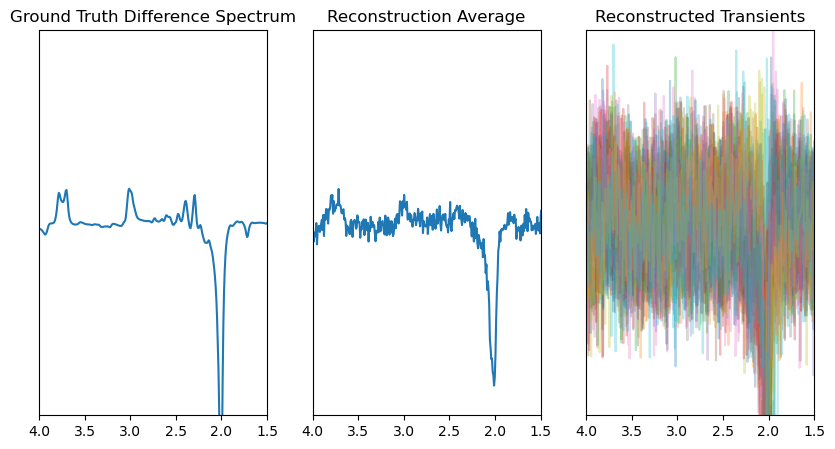

In [33]:
# The first step to add noise will be to copy the fid array and expand its dimensions to create a transient number index
noise_fid = np.expand_dims(fid.copy(),axis=3)

# let's make the fids with 40 transients per subspectra
noise_fid = np.repeat(noise_fid,40,axis=3)

# Amplitude noise
base_amplitude_noise = 10
amplitude_noise = np.random.normal(0,base_amplitude_noise,size=noise_fid.shape)

noise_fid = noise_fid+amplitude_noise

# frequency noise
freq_shift_std=20
freq_shifts = np.random.normal(0,freq_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(freq_shifts*t.reshape(t.shape[0],t.shape[1],1,1)*math.pi/2))

# phase noise
phase_shift_std=30
phase_shifts = np.random.normal(0,phase_shift_std,size = (noise_fid.shape[0],1,1,noise_fid.shape[3]))
noise_fid = noise_fid*np.exp(1j*(phase_shifts*np.ones((t.shape[0],t.shape[1],1,1))*math.pi/180))

#now let's compare the spectra with and without the noise
noise_spec = np.fft.fftshift(np.fft.ifft(noise_fid,axis=1),axes=1)
noise_diff_spec = noise_spec[0,:,1,:]-noise_spec[0,:,0,:]

fig,ax = plt.subplots(1,3,figsize = (10,5))

ax[0].plot(ppm[0],np.real(diff_spec[0]))
ax[0].set_title("Ground Truth Difference Spectrum")

ax[1].plot(ppm[0],np.real(noise_diff_spec.mean(axis=1)))
ax[1].set_title("Reconstruction Average")

for i in range(noise_diff_spec.shape[1]):
    ax[2].plot(ppm[0],np.real(noise_diff_spec[:,i]),alpha=0.3)
ax[2].set_title("Reconstructed Transients")

for i in range(3):
    ax[i].set_xlim(1.5,4)
    ax[i].invert_xaxis()
    ax[i].set_ylim(-1,1)
    ax[i].set_yticks([])


plt.show()